# this notebook acknowledgement from :
# https://www.kaggle.com/code/nitinsss/pruning-a-neural-network

# 1. What is Pruning?

Pruning is a way to reduce the size of a neural network by using compression. After a network is trained, it's weights are ranked according to their importance. A percentage of the weights are pruned away (as in set to zero), in accordance with their importance. We test the pruned model on a test set and if the performance still holds out, we prune more. 

We keep pruning until the performance remains satisfactory. The aim is to find the level of pruining that provides us with an acceptable compromise in performance for a decent reduction in the network size.

There are two basic approaches of Pruning:

* Weight Pruning

Here the individual weights are ranked are ranked according to their magnitudes and the ones with small values are deemed less important. 

* Neuron pruining

Here we rank entire neurons (units) according to their [L2 norm](https://en.wikipedia.org/wiki/Norm_(mathematics). The weights accociated with any neuron exist as columns in the weight matrices of a network. By setting entire columns to zero, we can essentially prune away entire neurons.

Following figure is a good repesentative diagram. Note that a synapse refers to the connection between any two neurons. When a weight is pruned, essentially this connection disappears. And when all weights associated with a neuron are pruned, the neuron gets a sum total input of zero, so basically it does nothing, i.e disappears.

![](https://i.imgur.com/ya0PWGI.jpg)

# 2. Importing Utilities

### Libraries and Modules

In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

### Fashion MNIST dataset

We will use the Fashion-MNIST dataset and train a vanilla Neural Network on it. Then we will apply various levels of pruning on it, and then test the pruned versions on the test set.

Note - Trun on the internet in the settings of the Kernel.

In [2]:

((X_train, Y_train), (X_test, Y_test)) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


Create a dictionary of all classes in the target

In [3]:
class_labels = pd.Series(['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Code', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'])
labels_dict = class_labels.to_dict()
labels_dict

{0: 'T-shirt',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Code',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle Boot'}

Fetch 5 images at random from the training data, plot them and fetch their corresponding labels from the training targets.

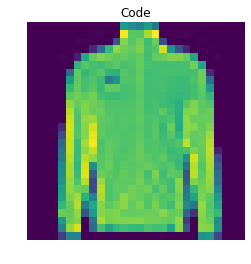

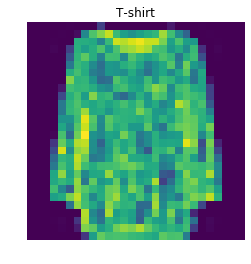

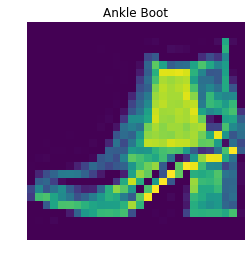

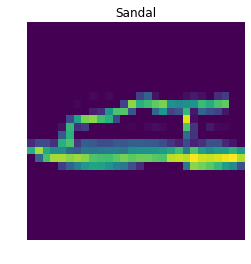

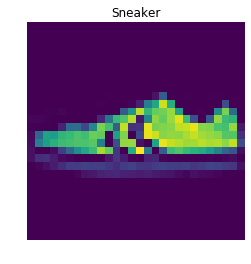

In [4]:
np.random.seed(40)
for rand_num in np.random.randint(0, len(X_train), 5):
    plt.figure()
    plt.imshow(X_train[rand_num]), plt.axis('off')
    plt.title(labels_dict[Y_train[rand_num]])

# 3. Data preprocessing

### Reshaping input data, and normalizing it

We will reshape the image data from 28x28 to 784x1, and normalize all values between 0 and 1.

In [5]:
X_train_reshaped = X_train.reshape(len(X_train), -1)   
X_test_reshaped = X_test.reshape(len(X_test), -1)

X_train_norm = X_train_reshaped/255            
X_test_norm = X_test_reshaped/255

In [6]:
n_features = X_train_norm.shape[1]
n_classes =  len(class_labels)

print('Number of input features (image pixels) : ', n_features)
print('Number of target classes (fashion categories) : ', n_classes)

Number of input features (image pixels) :  784
Number of target classes (fashion categories) :  10


### One-Hot transformation of Target Data

In [7]:
Y_train_onehot = to_categorical(Y_train, num_classes = n_classes)
Y_test_onehot = to_categorical(Y_test, num_classes = n_classes)

### Creation of a Validation set

We need to separate out a validation set from the training set, that is to be used while traing the network to keep an eye on overfitting ot underfitting.

In [8]:
X_train_final, X_valid, Y_train_final, Y_valid = train_test_split(X_train_norm, Y_train_onehot, 
                                                                  test_size=0.16666)

print('Shape of data used for training, and shape of training targets : \n ', X_train.shape, ',', Y_train.shape)
print('Shape of data used for validation, and shape of validation targets: \n ', X_valid.shape, ',', Y_valid.shape)

Shape of data used for training, and shape of training targets : 
  (60000, 28, 28) , (60000,)
Shape of data used for validation, and shape of validation targets: 
  (10000, 784) , (10000, 10)


# 4. Neural Network set-up

We will use five dense layers. We will set 'bias' to false for now, since that will make the weight matrices easier to work with. The weights of the final dense layers (the one leading to the output nodes) will not be pruned. But first, let's create the model and train it.

In [9]:
model = Sequential()
model.add(Dense(1000, input_dim = n_features, activation='relu', use_bias=False))
model.add(Dense(1000, activation='relu', use_bias=False))
model.add(Dense(500, activation='relu', use_bias=False))
model.add(Dense(200, activation='relu', use_bias=False))
model.add(Dense(n_classes, activation='softmax', use_bias=False))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              784000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1000000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500000    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100000    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2000      
Total params: 2,386,000
Trainable params: 2,386,000
Non-trainable params: 0
_________________________________________________________________


### Saving the model while it trains

By using 'Callback' and 'ModelCheckpoint'utilities of Keras, we can save the model with the best weights. By 'best', I mean the ones that gave the best performance over the validation set while training. It checks if the performance of model with updated weights after every epoch is better than the performance of the saved model.

In [10]:
save_at = "/kaggle/working/model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, 
                             save_best_only=True, save_weights_only=False, mode='max')

### Training of Neural Network

Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 46s 910us/sample - loss: 0.4886 - accuracy: 0.8268 - val_loss: 0.3903 - val_accuracy: 0.8569
Epoch 2/12
50000/50000 [==============================] - 45s 892us/sample - loss: 0.3493 - accuracy: 0.8729 - val_loss: 0.3813 - val_accuracy: 0.8600
Epoch 3/12
50000/50000 [==============================] - 45s 905us/sample - loss: 0.3084 - accuracy: 0.8869 - val_loss: 0.3276 - val_accuracy: 0.8817
Epoch 4/12
50000/50000 [==============================] - 44s 889us/sample - loss: 0.2805 - accuracy: 0.8962 - val_loss: 0.3319 - val_accuracy: 0.8791
Epoch 5/12
50000/50000 [==============================] - 45s 910us/sample - loss: 0.2578 - accuracy: 0.9039 - val_loss: 0.3051 - val_accuracy: 0.8917
Epoch 6/12
50000/50000 [==============================] - 45s 900us/sample - loss: 0.2358 - accuracy: 0.9113 - val_loss: 0.3111 - val_accuracy: 0.8923
Epoch 7/12
50000/50000 [====================

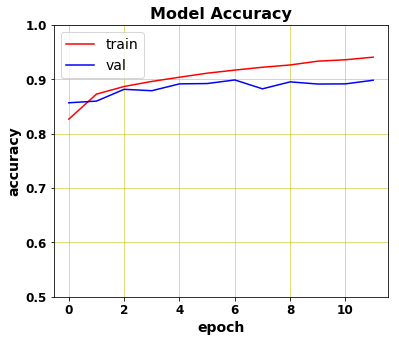

In [11]:
history = model.fit( X_train_final, Y_train_final, 
                    epochs = 12, batch_size = 20, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_valid, Y_valid) )

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.5, 1)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Testing 
Let's check the model's score on the test set

In [12]:
score = model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  89.2 %


We will now plot 5 images at random from test set, but with titles as classified by the model, with every correct classification titled in 'green' color, and every incorrect classification titles in 'red' color.

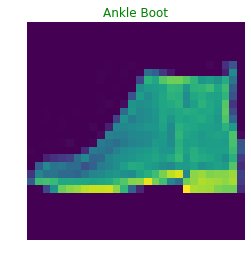

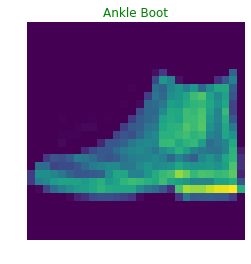

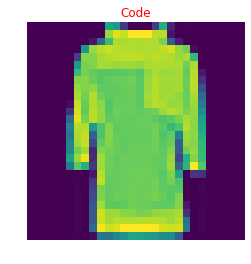

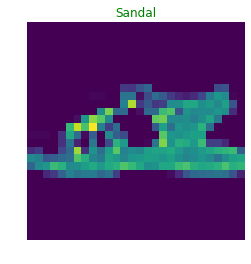

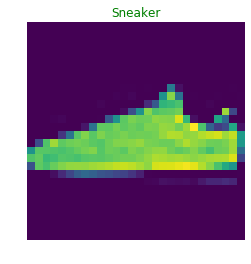

In [13]:
Y_pred = np.round(model.predict(X_test_norm))

np.random.seed(50)
for rand_num in np.random.randint(0, len(Y_test_onehot), 5):
    plt.figure()
    plt.imshow(X_test[rand_num]), plt.axis('off')
    if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test_onehot[rand_num] == 1)[0].sum():
        plt.title(labels_dict[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
    else :
        plt.title(labels_dict[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

# 5. Pruning Strategy

The strategy is simple. The weights of the network will be accessed layer wise. Each layer has two weight matrices - first one for link weights, and the second one for bias weights of every neuron of that layer. Since we are not using biases, we only have to worry about one matrix per layer for now.

For weight pruning, we will create a dictionary of the weights, with every key being a three valued tuple. The first value having the layer number, second and third values having the row and column number from that layer's weight matrix.

Each row number is in fact the neuron number from previous layer, and each column number is the neuron number of that particular layer. So, for neuron pruning, unlike weight pruining where we want to create a weights dictionary, here we will have a dictionary that contains column arrays. The key will be a two valued tuple. First value representing the layer number, and the second one representing the column number.

We will sort the weights in the weights dictionary according to their absolute values, and the weight vectors in the neuron dictionary according to their L2 norm.

We will then map the weights (or columns) from the sorted dictionaries on to the trained neural network and set the weights (or columns) to zero to obtain our compresed Neural Networks (with the set pruing level).

In [14]:
trained_model = load_model("/kaggle/working/model.hdf5")

trained_model.layers

In [15]:
total_no_layers = len(trained_model.layers)
print(total_no_layers)

5


We will start with zero pruning and graudally increase the level of pruning up unit 99%, and keep checking the pruned model's performance after every increase.

In [16]:
#Pruning percentages

K = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]   

# 6. Weight Pruning

In [33]:
all_weights = {}

for layer_no in range(total_no_layers - 1):         #All except the final layer                                                                          #only the first four dense layers are to be pruned
    layer_weights = (pd.DataFrame(trained_model.layers[layer_no].get_weights()[0]).stack()).to_dict() 
    layer_weights = { (layer_no, k[0], k[1]): v for k, v in layer_weights.items() }
    all_weights.update(layer_weights)

In [34]:
all_weights_sorted = {k: v for k, v in sorted(all_weights.items(), key=lambda item: abs(item[1]))}

In [35]:
total_no_weights = len(all_weights_sorted) 
total_no_weights 

2384000

In [36]:
weight_pruning_scores = []

for pruning_percent in K:

    new_model = load_model("/kaggle/working/model.hdf5")
    new_weights = trained_model.get_weights().copy()

    prune_fraction = pruning_percent/100
    number_of_weights_to_be_pruned = int(prune_fraction*total_no_weights)
    weights_to_be_pruned = {k: all_weights_sorted[k] for k in list(all_weights_sorted)[ :  number_of_weights_to_be_pruned]}     

    for k, v in weights_to_be_pruned.items():
        new_weights[k[0]][k[1], k[2]] = 0

    for layer_no in range(total_no_layers - 1) :
        new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
        new_model.layers[layer_no].set_weights(new_layer_weights)
    
    new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
    weight_pruning_scores .append(new_score[1])

# 7. Neuron Pruning

In [28]:
all_neurons = {}

for layer_no in range(total_no_layers - 1):         

    layer_neurons = {}
    layer_neurons_df = pd.DataFrame(trained_model.layers[layer_no].get_weights()[0])

    for i in range(len(layer_neurons_df.columns)):
        layer_neurons.update({ i : np.array( layer_neurons_df.iloc[:,i] ) })    
                                                                 
    layer_neurons = { (layer_no, k): v for k, v in layer_neurons.items() }
    all_neurons.update(layer_neurons)

In [29]:
all_neurons_sorted = {k: v for k, v in sorted(all_neurons.items(), key=lambda item: np.linalg.norm(item[1], ord=np.inf, axis=0))}


In [30]:
total_no_neurons = len(all_neurons_sorted) 
total_no_neurons 

2700

In [31]:
neuron_pruning_scores = []

for pruning_percent in K:

    new_model = load_model("/kaggle/working/model.hdf5")
    new_weights = trained_model.get_weights().copy()

    prune_fraction = pruning_percent/100
    number_of_neurons_to_be_pruned = int(prune_fraction*total_no_neurons)
    neurons_to_be_pruned = {k: all_neurons_sorted[k] for k in list(all_neurons_sorted)[ : number_of_neurons_to_be_pruned]}     

    for k, v in neurons_to_be_pruned.items():
        new_weights[k[0]][:, k[1]] = 0

    for layer_no in range(total_no_layers - 1) :
        new_layer_weights = new_weights[layer_no].reshape(1, new_weights[layer_no].shape[0], new_weights[layer_no].shape[1])
        new_model.layers[layer_no].set_weights(new_layer_weights)
    
    new_score  = new_model.evaluate(X_test_norm, Y_test_onehot, verbose=0)
    neuron_pruning_scores.append(new_score[1])

# 8. Pruning Results

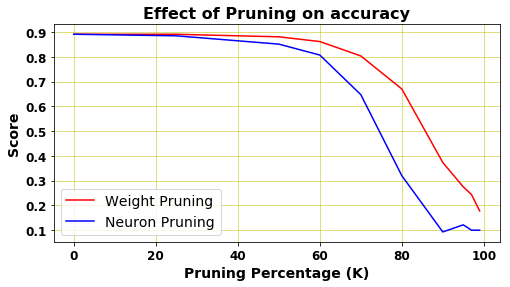

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(pd.DataFrame(weight_pruning_scores).set_index(pd.Series(K), drop=True) , color='r')
plt.plot(pd.DataFrame(neuron_pruning_scores).set_index(pd.Series(K), drop=True) , color='b')
plt.title('Effect of Pruning on accuracy', weight='bold', fontsize=16)
plt.ylabel('Score', weight='bold', fontsize=14)
plt.xlabel('Pruning Percentage (K)', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['Weight Pruning', 'Neuron Pruning'], loc='best', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

# 9. Observations

We are able to prune upto 60% of the weights with a tolerable dip in accuracy.

We are able to prune upto 15% of the neurons with a tolerable dip in accuracy.

For weight pruining as high a 80%, the accuracy of the pruned model is still decent. 

This suggests that Neural Networks are highly robust. Even if a large protion of the less significant weights are removed, the other significant weights are still able to generate a good enough result.

Train on 50000 samples, validate on 10000 samples
Epoch 1/12
50000/50000 [==============================] - 38s 765us/sample - loss: 0.8299 - accuracy: 0.6795 - val_loss: 0.5249 - val_accuracy: 0.8125
Epoch 2/12
50000/50000 [==============================] - 38s 753us/sample - loss: 0.4444 - accuracy: 0.8420 - val_loss: 0.4132 - val_accuracy: 0.8542
Epoch 3/12
50000/50000 [==============================] - 38s 755us/sample - loss: 0.3744 - accuracy: 0.8649 - val_loss: 0.3799 - val_accuracy: 0.8641
Epoch 4/12
50000/50000 [==============================] - 38s 751us/sample - loss: 0.3407 - accuracy: 0.8759 - val_loss: 0.3916 - val_accuracy: 0.8570
Epoch 5/12
50000/50000 [==============================] - 38s 752us/sample - loss: 0.3186 - accuracy: 0.8837 - val_loss: 0.3350 - val_accuracy: 0.8790
Epoch 6/12
50000/50000 [==============================] - 38s 753us/sample - loss: 0.2988 - accuracy: 0.8900 - val_loss: 0.3297 - val_accuracy: 0.8831
Epoch 7/12
50000/50000 [====================

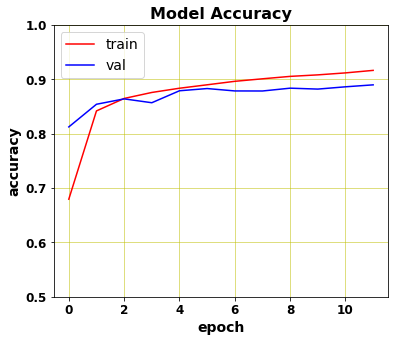

In [26]:
history = new_model.fit( X_train_final, Y_train_final, 
                    epochs = 12, batch_size = 20, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_valid, Y_valid) )

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.5, 1)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()